# Libraries

In [22]:
import os
import cv2
import numpy as np
import string
import matplotlib.pyplot as plt

# Handling the dataset

- The main focus was on building an acceptable letter recognition model. If this was successful, the model can be easily adapted for digits and special characters.
- All image files were stored in a folder and were named after their ASCII value

## Helper functions

- letterIndex: Returns the alphabetical location of a given uppercase letter
- load: Reads all image files from a given folder, flattens them into numpy arrays and merges them together into a large dataset, keeping the image data and labels separate

In [4]:
def letterIndex(i):
    return int(i) - 65

def load(folder):
    files = os.listdir(folder)
    n = len(files)
    
    labels = np.array([letterIndex(i[0:2]) for i in files]).reshape(n, 1)
    flattened = []
    
    for i in range(n):
        path = os.path.join(folder, files[i])
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        flat = image.flatten()
        flattened.append(flat)

    # Combine images and labels into 1 dataset
    images = np.vstack(flattened)
    dataset = np.hstack((labels, images))

    # Randomize the data
    np.random.shuffle(dataset)
    images = dataset[:, 1:]
    labels = dataset[:, 0]
    
    return images, labels 

In [5]:
pixels, labels = load('Letters uppercase')
print(labels.shape)

(16257,)


## Preview images

- Examine some images to ensure they have been loaded correctly

In [7]:
dimension = (64, 64)

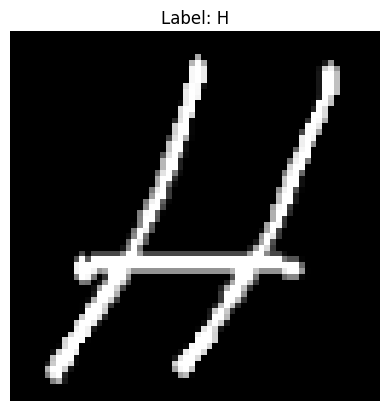

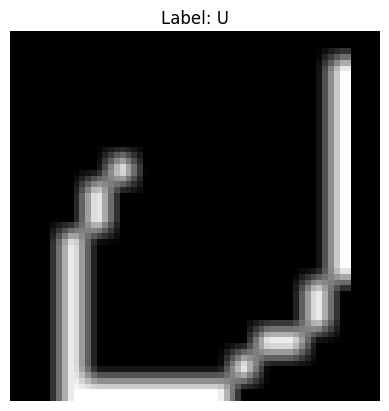

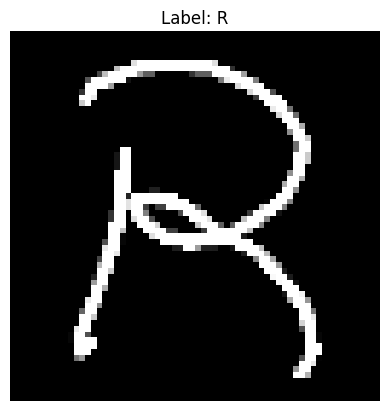

In [8]:
images = pixels.reshape((-1, *dimension))

alphabet = string.ascii_uppercase

for i in range(3):
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {alphabet[labels[i]]}")
    plt.axis('off')
    plt.show()

## Split data for training and testing

- The labels form a 1D numpy array and so their length represents the number of exmples in the entire dataset
- The split was 80% training and 20% testing

In [9]:
split = labels.shape[0]
start = int(split * 0.8)

X_train = pixels[:start]
y_train = labels[:start]

X_test = pixels[start:split]
y_test = labels[start:split]

print(f"X Train: {X_train.shape}")
print(f"y Train: {y_train.shape}")
print()
print(f"X Test: {X_test.shape}")
print(f"y Test: {y_test.shape}")

X Train: (13005, 4096)
y Train: (13005,)

X Test: (3252, 4096)
y Test: (3252,)


<br>

# Build the neural network

- Using objects helped manipulate values in a tidy manner
- Intermediate values are the values produced by multiplying the input by the weights and then adding the bias. W(X) + b
- Activation values are the values produced by applying the ReLU or Softmax function on the intermediate values

In [10]:
class Layer:
    def __init__(self, neurons, features):
        self.weights = np.random.rand(neurons, features) - 0.5
        self.biases = np.random.rand(neurons, 1) - 0.5
        self.intermediate = 0
        self.activation = 0

## Convolution layer

- Although the convolution layer is not integrated with the main part of the network, the network still produced good results. This layer does not change with gradient descent
- Without this layer, the model struggled to acheive an accuracy of above 80% when given more than 2000 training examples.
- The convolution layer ensures the patterns within each exmaples are being examined rather than checking if individual pixels match other examples 


### Filtering

- Takes a matrix of flattened images and a given 3x3 filter to carry out the filtering process

In [11]:
def filtering(input, filter):
    n = input.shape[0]
    features = input.shape[1]
    image_size = int(features**0.5)
    filter_size = filter.shape[1]

    mini = []
    
    # Identifies which indices need to be accessed - 3x3 grid
    location = np.arange(image_size**2).reshape((image_size, image_size))
    for row in range(1, image_size-1):
        for column in range(1, image_size-1):
            filter_grid = location[row-1:row+2, column-1:column+2].flatten()
            grid = input[:, filter_grid]
            mean = grid.dot(filter.T) / filter_size
            mini.append(mean)

    bitmap = np.hstack(mini)      
    return bitmap

### Max pooling

- Slides a 2x2 grid across the filtered image and takes the largest pixel value within the grid

In [12]:
def relu(Z):
    return np.maximum(0, Z)


def pooling(input):
    # 2x2 kernel
    pool_kernel = 2
    features = input.shape[1]
    pool_size = int(features**0.5)

    mini = []
    
    # Identifies which indices need to be accessed - 2x2 grid
    location = np.arange(features).reshape((pool_size, pool_size))
    for row in range(0, pool_size, pool_kernel):
        for column in range(0, pool_size, pool_kernel):
            pool_grid = location[row:row+pool_kernel, column:column+pool_kernel].flatten()

            # Get the maximum value from each row in the matrix
            maximum = input[:, pool_grid].max(1).reshape((-1, 1))
            mini.append(maximum.round())
    
    result = np.hstack(mini) 
    return result
    

### Combining the processes

- process: Takes a matrix of flattened images and a filter to perform both filtering and max pooling
- convolution: Applies the entire convolution process with 3 different filters. These filters try to detect vertical, horizontal and diagonal edges in each image
- The inputs for the training and testing sets are transposed so that the values used throughout the network are easier to handle as they maintain the shape of each layer. The inputs are also divided by 255 as this is the largest possible value for a pixel and normalizes the inputs so that each value could be between 0 and 1 which also makes values easier to handle

In [13]:
def process(images, filter):
    bitmap = filtering(images, filter)
    adjusted = relu(bitmap)
    result = pooling(adjusted)
    return result

def convolution(images):
    all = []
    # Vertical filter
    vertical = np.array([[1, 0, -1, 1, 0, -1, 1, 0, -1]])  
    result = process(images, vertical)
    all.append(result)
    
    # Horizontal filter
    horizontal = np.array([[1, 1, 1, 0, 0, 0, -1, -1, -1]]) 
    result1 = process(images, horizontal)
    all.append(result1)

    # Diagonal filter
    diagonal = np.array([[1, 1, 0, 1, 0, -1, 0, -1, -1]])  
    result2 = process(images, diagonal)
    all.append(result2)
    
    final = np.hstack(all)
    return final

In [14]:
C_train = convolution(X_train).T / 255.0
C_test = convolution(X_test).T / 255.0

print(C_train.shape)
print(C_test.shape)

(2883, 13005)
(2883, 3252)


## Forward

- ReLU has already been defined
- softmax: Takes an input where the rows represent a value of the example belonging to a certain class and the columns represent each example. Since there are 26 possible classes (26 letters of the alphabet), the input data will have 26 rows. The softmax function then converts the values into probabilities of each example belonging to each class.
- forward: Takes in a matrix of flattened images and then each layer of the network. The intermediate values (Z-values) and the activation values (A-values) are computed and returned.

In [15]:
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A


def forward(X, L1, L2, output):
    W1 = L1.weights
    b1 = L1.biases
    W2 = L2.weights
    b2 = L2.biases
    W3 = output.weights
    b3 = output.biases

    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    
    return Z1, A1, Z2, A2, Z3, A3

## Gradient descent

- This algorithm ensures the model learns how to improve itself to achieve higher accuracy
- backward: Carries out backward propagation. All values from all the layers of the neural network are accessed. The chain rule with partial differentiation is used to determine the change of the output when the weights and biases change
- update: Adjusts the parameters of all layers by taking the derivatives of parameters and taking a given learning rate value denoted by alpha. The larger the alpha value, the larger "steps" will be taken when adjusting the parameters to minimize the cost of the network 

In [16]:
def backward(X, y, L1, L2, output):
    W1 = L1.weights
    b1 = L1.biases
    Z1 = L1.intermediate
    A1 = L1.activation

    W2 = L2.weights
    b2 = L2.biases
    Z2 = L2.intermediate
    A2 = L2.activation    

    W3 = output.weights
    b3 = output.biases
    Z3 = output.intermediate
    A3 = output.activation

    n = X.shape[1]
    dj_Z3 = A3.copy()
    dj_Z3[y, range(n)] -= 1 # Each column is an example's probabilities

    # Output layer
    dZ3_W3 = A2.T
    dZ3_b3 = 1
    dW3 = dj_Z3.dot(dZ3_W3) / n
    db3 = np.mean(dj_Z3 * dZ3_b3)

    
    # 2nd layer
    dZ3_A2 = W3.T 
    dA2_Z2 = Z2 > 0 # Derivative of Relu
    dj_Z2 = dZ3_A2.dot(dj_Z3) * dA2_Z2
    
    dZ2_W2 = A1.T
    dZ2_b2 = 1
    dW2 = (dj_Z2.dot(dZ2_W2)) / n
    db2 = np.mean(dj_Z2 * dZ2_b2)

    
    # 1st layer
    dZ2_A1 = W2.T 
    dA1_Z1 = Z1 > 0 # Derivative of Relu
    dj_Z1 = dZ2_A1.dot(dj_Z2) * dA1_Z1
    
    dZ1_W1 = X.T
    dZ1_b1 = 1
    dW1 = (dj_Z1.dot(dZ1_W1)) / n
    db1 = np.mean(dj_Z1 * dZ1_b1)
    
    return dW1, db1, dW2, db2, dW3, db3


def update(L1, L2, output, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = L1.weights.copy() - (alpha * dW1)
    b1 = L1.biases.copy() - (alpha * db1)
    W2 = L2.weights.copy() - (alpha * dW2)
    b2 = L2.biases.copy() - (alpha * db2)    
    W3 = output.weights.copy() - (alpha * dW3)
    b3 = output.biases.copy() - (alpha * db3)

    return W1, b1, W2, b2, W3, b3

## Performance

- get_predictions: Returns the highest probability for each example in the given matrix
- get_loss: Returns the loss of each example by comparing its highest probability to its actual class. The sum of loss across all examples results in the cost function
- get_accuracy: Returns the portion of correct predictions out of all predictions made
- performance: Prints the accuracy of predictions for every 10 iterations

In [17]:
def get_predictions(A):
    return np.argmax(A, 0)

def get_loss(predictions, y):
    n = predictions.shape[1]
    labelled = predictions[y, range(n)]
    cost = np.sum(-np.log(labelled))
    return cost

def get_accuracy(predictions, y):
    accuracy = np.sum(predictions == y) / y.size
    return accuracy

def performance(y_hat, y, iterations, cost, accuracy_array, i, insert):
    if i % 10 == 0:
        predictions = get_predictions(y_hat)
        accuracy = get_accuracy(predictions, y)
        loss = get_loss(y_hat, y)
    
        if insert < (iterations / 10):
            cost[insert] = loss
            accuracy_array[insert] = accuracy * 100
            insert += 1
        
        
        print(f"Iteration: {i}, Loss: {round(loss, 5)}, Accuracy: {round(accuracy * 100, 5)}%")
            
    return insert

## Main network

- Combines all processes of the network
- Implementing mini-batches significantly improved training accuracy as the input surpassed 4000 examples

In [18]:
def network(X, y, batch, alpha, iterations):
    cost = np.zeros([iterations // 10])
    accuracy_array = cost.copy()
    insert = 0

    n = y.shape[0]
    features = X.shape[0]
    batch_limit = n//batch
    
    L1 = Layer(48, features)
    L2 = Layer(34, 48)
    out = Layer(26, 34)
    
    for i in range(1, iterations+1):
        for j in range(batch_limit):
            current = (j) * batch
            upper = (j+1) * batch
            
            if j == batch_limit-1:
                upper = n
            mini_X = X[:, current:upper]
            mini_y = y[current:upper]
            
            Z1, A1, Z2, A2, Z3, A3 = forward(mini_X, L1, L2, out)
            L1.intermediate = Z1
            L1.activation = A1
            L2.intermediate = Z2
            L2.activation = A2
            out.intermediate = Z3
            out.activation = A3
            
            dW1, db1, dW2, db2, dW3, db3 = backward(mini_X, mini_y, L1, L2, out)
            W1, b1, W2, b2, W3, b3 = update(L1, L2, out, dW1, db1, dW2, db2, dW3, db3, alpha)
    
            L1.weights = W1
            L1.biases = b1
            L2.weights = W2
            L2.biases = b2
            out.weights = W3
            out.biases = b3

            if j == batch_limit-1:
                insert = performance(A3, mini_y, iterations, cost, accuracy_array, i, insert)

    return L1, L2, out, cost, accuracy_array

In [19]:
batch_size = 24
alpha = 0.085
iterations = 50

L1, L2, out, cost, accuracy = network(C_train, y_train, batch_size, alpha, iterations)

Iteration: 10, Loss: 13.51661, Accuracy: 91.11111%
Iteration: 20, Loss: 7.20183, Accuracy: 97.77778%
Iteration: 30, Loss: 1.41864, Accuracy: 100.0%
Iteration: 40, Loss: 0.60815, Accuracy: 100.0%
Iteration: 50, Loss: 0.34053, Accuracy: 100.0%


# Testing

- The best performing model with the same neurons, batch size, learning rate and number of epochs was 100% on training and 85% on testing

In [20]:
def feed(X, L1, L2, output):
    W1 = L1.weights
    b1 = L1.biases
    W2 = L2.weights
    b2 = L2.biases
    W3 = output.weights
    b3 = output.biases

    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = relu(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    
    return A3

In [21]:
y_hat_test = feed(C_test, L1, L2, out)
test_predictions = np.argmax(y_hat_test, 0)

test_accuracy = get_accuracy(test_predictions, y_test)
print(f"Accuracy: {round(test_accuracy * 100, 5)}%")

Accuracy: 84.34809%


## Visualize training

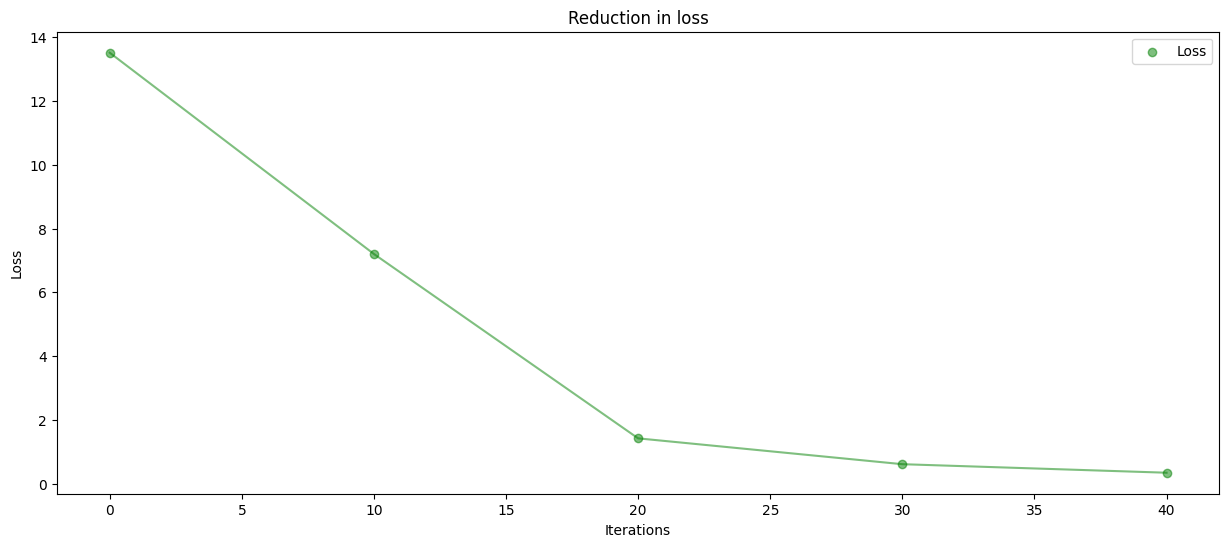

In [24]:
epoch = np.arange(0, iterations, 10)

plt.figure(figsize=(15, 6)) 
plt.plot(epoch, cost, alpha=0.5, color='green')
plt.scatter(epoch, cost, alpha=0.5, color='green', label='Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Reduction in loss')
plt.legend()  

plt.show()

#### The model was initialized repeatedly until the best results were achieved. The parameters of the best model is saved as a numpy matrix using the following code

In [ ]:
np.savez()